In [65]:
from __future__ import print_function
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)

In [66]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()
# model_ctx = mx.gpu()

In [67]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
mnist_train = gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.MNIST(train=False, transform=transform)
##USPS_test = gluon.data.vision.USPS(train=False, transform=transform)

AttributeError: module 'mxnet.gluon.data.vision' has no attribute 'USPS'

In [ ]:
#image, label = mnist_train[0]
#print(image.shape, label)

In [68]:
num_inputs = 784
num_outputs = 10
num_examples = 60000

In [46]:
#im = mx.nd.tile(image, (1,1,3))
#print(im.shape)

In [47]:
import matplotlib.pyplot as plt
#plt.imshow(im.asnumpy())
#plt.show()

In [48]:
batch_size = 128
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)

In [49]:
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

In [50]:
W = nd.random_normal(shape=(num_inputs, num_outputs),ctx=model_ctx)
b = nd.random_normal(shape=num_outputs,ctx=model_ctx)

params = [W, b]

In [51]:
for param in params:
    param.attach_grad()

In [52]:
def softmax(y_linear):
    exp = nd.exp(y_linear-nd.max(y_linear, axis=1).reshape((-1,1)))
    norms = nd.sum(exp, axis=1).reshape((-1,1))
    return exp / norms
sample_y_linear = nd.random_normal(shape=(2,10))
sample_yhat = softmax(sample_y_linear)
print(sample_yhat)


[[0.38854712 0.15868285 0.09794893 0.01202093 0.01595045 0.04553349
  0.14224595 0.03143111 0.04231628 0.06532289]
 [0.08514825 0.43826103 0.02771222 0.08836042 0.17408127 0.05132056
  0.02093019 0.06935012 0.03025254 0.01458343]]
<NDArray 2x10 @cpu(0)>


In [53]:
print(nd.sum(sample_yhat, axis=1))


[1. 1.]
<NDArray 2 @cpu(0)>


In [54]:
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    return yhat

In [55]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat+1e-6))

In [56]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [57]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

In [58]:
evaluate_accuracy(test_data, net)

0.1167

In [59]:
epochs = 10
learning_rate = .005

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()


    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

Epoch 0. Loss: 1.396563060061137, Train_acc 0.8533, Test_acc 0.8582
Epoch 1. Loss: 0.618119808959961, Train_acc 0.88126665, Test_acc 0.8816
Epoch 2. Loss: 0.5206775095939636, Train_acc 0.89235, Test_acc 0.891
Epoch 3. Loss: 0.4691974454561869, Train_acc 0.89795, Test_acc 0.8938
Epoch 4. Loss: 0.435767606306076, Train_acc 0.90213335, Test_acc 0.8974
Epoch 5. Loss: 0.4112333960692088, Train_acc 0.90506667, Test_acc 0.9003
Epoch 6. Loss: 0.39365762849648794, Train_acc 0.90863335, Test_acc 0.9036
Epoch 7. Loss: 0.3775407210667928, Train_acc 0.9116333, Test_acc 0.907
Epoch 8. Loss: 0.36614698506991067, Train_acc 0.9084833, Test_acc 0.9062
Epoch 9. Loss: 0.35546985478401183, Train_acc 0.91531664, Test_acc 0.9084


(10, 28, 28, 1)


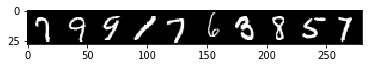

model predictions are: 
[7. 9. 9. 1. 7. 6. 8. 8. 5. 7.]
<NDArray 10 @cpu(0)>


In [60]:
# Define the function to do prediction
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mnist_test, 10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break

In [61]:
#rom PIL import Image
#import os
#import numpy as np

In [63]:
USPStest_data = mx.gluon.data.DataLoader(USPS_test, batch_size, shuffle=False)

In [64]:
evaluate_accuracy(USPStest_data, net)

ValueError: too many values to unpack (expected 2)

In [ ]:
epochs = 10
learning_rate = .005

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()


    test_accuracy = evaluate_accuracy(USPStest_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))